In [7]:
# importing required libraries
library(keras)
library(imager)
library(graphics)

In [8]:
# loading the data
labels <- read.csv('data/raccoon_dataset/raccoon_labels.csv')

# Displaying first 5 rows of data
head(labels)

filename,width,height,class,xmin,ymin,xmax,ymax
raccoon-1.jpg,650,417,raccoon,81,88,522,408
raccoon-10.jpg,450,495,raccoon,130,2,446,488
raccoon-100.jpg,960,576,raccoon,548,10,954,520
raccoon-101.jpg,640,426,raccoon,86,53,400,356
raccoon-102.jpg,259,194,raccoon,1,1,118,152
raccoon-103.jpg,480,640,raccoon,92,54,460,545


       filename width height   class xmin ymin xmax ymax
1 raccoon-1.jpg   650    417 raccoon   81   88  522  408


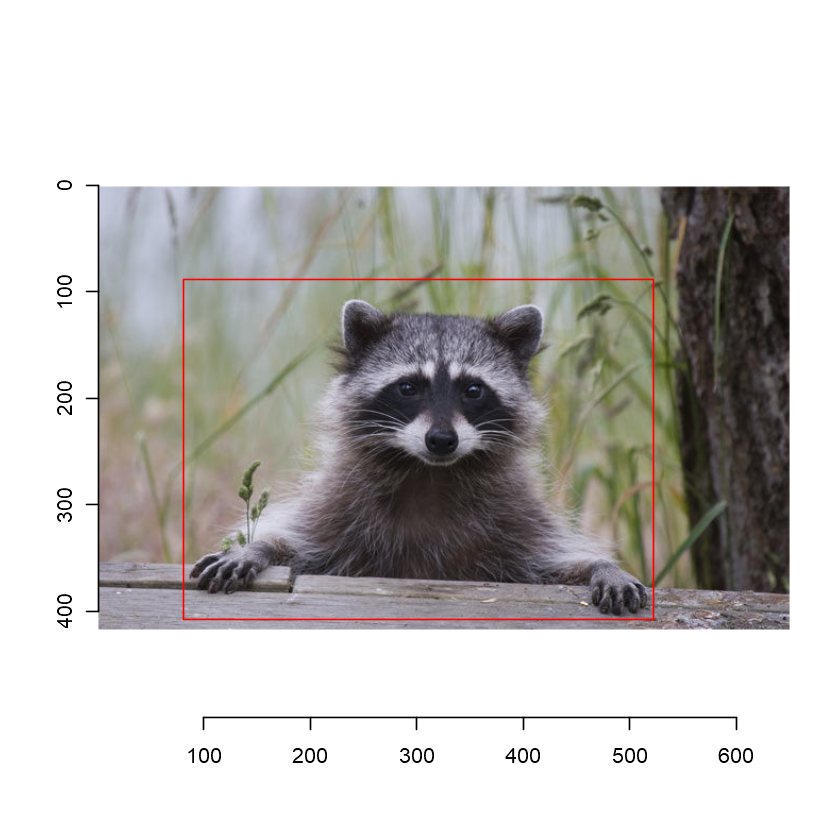

In [9]:
# plotting a sample image with bounding box from the given coordinates in the data
im <- load.image('data/raccoon_dataset/images/raccoon-1.jpg')
im_info = labels[labels$filename == 'raccoon-1.jpg' ,]
print(im_info)
plot(im)
rect(xleft = im_info$xmin ,ybottom = im_info$ymin,xright = im_info$xmax,ytop = im_info$ymax,border = "red",lwd = 1)

In [10]:
# fixing image width and height and initializing network parameters
image_channels = 3
batch_size = 15
image_width_resized = 96
image_height_resized = 96
model_name = "raccoon_1_"

In [11]:
# rescaling the coordinates of the bounding box according to the new image dimensions
labels$x_min_resized = (labels[,'xmin']/(labels[,'width']) * image_width_resized)%>% round()
labels$y_min_resized = (labels[,'ymin']/(labels[,'height']) * image_height_resized)%>% round()
labels$x_max_resized = (labels[,'xmax']/(labels[,'width']) * image_width_resized)%>% round()
labels$y_max_resized = (labels[,'ymax']/(labels[,'height']) * image_height_resized)%>% round()

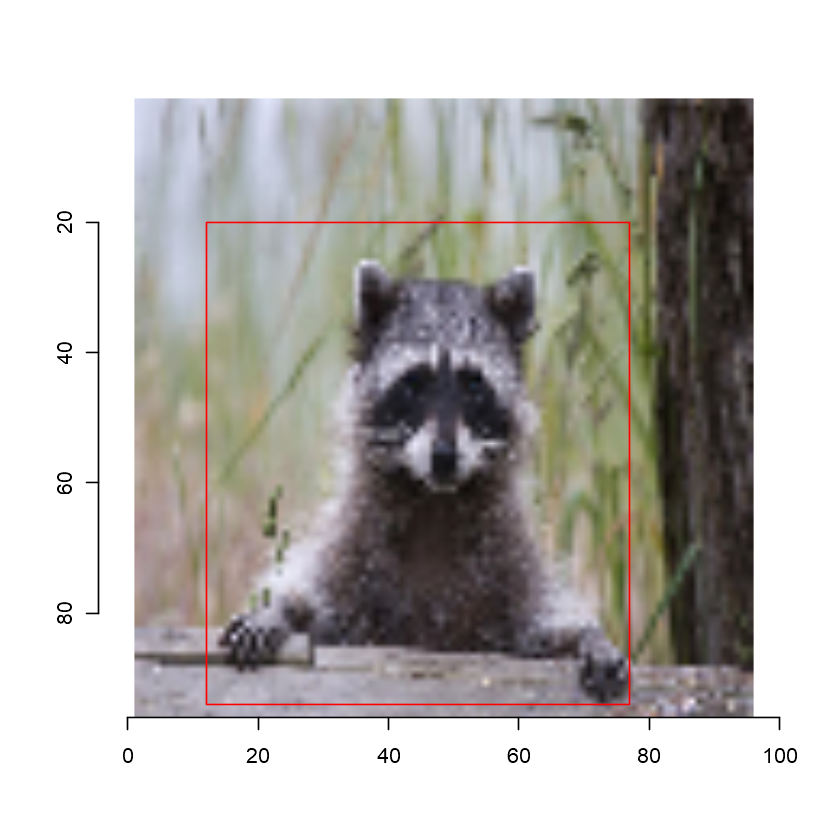

In [20]:
# displaying the resized version of the same example 
x <-labels[labels$filename == 'raccoon-1.jpg',]
im_resized <- resize(im = im,size_x = image_width_resized,size_y = image_height_resized)
plot(im_resized)
rect(xleft = x$x_min_resized,ybottom = x$y_min_resized,xright = x$x_max_resized ,ytop = x$y_max_resized,border = "red",lwd = 1)

In [21]:
# splitting the data into training,validation and test datasets
X_train <- labels[1:150,]
X_val <- labels[151:200,]
X_test <- labels[201:nrow(labels),]

In [3]:
#  defining a function for calculating the custom metric for our model, i.e. intersection over union(IOU)
metric_iou <- function(y_true, y_pred) {
    
  intersection_x_min_resized <- k_maximum(y_true[ ,1], y_pred[ ,1])
  intersection_y_min_resized <- k_maximum(y_true[ ,2], y_pred[,2])
  intersection_x_max_resized <- k_minimum(y_true[ ,3], y_pred[ ,3])
  intersection_y_max_resized <- k_minimum(y_true[ ,4], y_pred[ ,4])
  
  area_intersection <- (intersection_x_max_resized - intersection_x_min_resized) * 
                       (intersection_y_max_resized - intersection_x_max_resized)
  area_y <- (y_true[ ,3] - y_true[ ,1]) * (y_true[ ,4] - y_true[ ,2])
  area_yhat <- (y_pred[ ,3] - y_pred[ ,1]) * (y_pred[ ,4] - y_pred[ ,2])
  area_union <- area_y + area_yhat - area_intersection
  
  iou <- area_intersection/area_union
  k_mean(iou)
#     c(area_y,area_yhat,area_intersection,area_union,iou)
}

In [22]:
# instantiating a VGG16 model with imagenet weights
feature_extractor <- application_vgg16(include_top = FALSE,
    weights = "imagenet",
    input_shape = c(image_width_resized, image_height_resized,image_channels)
)

In [38]:
# adding layers to VGG16 network and building model
output <- feature_extractor$output %>%
    layer_conv_2d(filters = 4,kernel_size = 3) %>%
    layer_reshape(c(4))


model <- keras_model(inputs = feature_extractor$input, outputs = output)

In [40]:
# summary of the model
summary(model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_3 (InputLayer)                (None, 96, 96, 3)               0           
________________________________________________________________________________
block1_conv1 (Conv2D)               (None, 96, 96, 64)              1792        
________________________________________________________________________________
block1_conv2 (Conv2D)               (None, 96, 96, 64)              36928       
________________________________________________________________________________
block1_pool (MaxPooling2D)          (None, 48, 48, 64)              0           
________________________________________________________________________________
block2_conv1 (Conv2D)               (None, 48, 48, 128)             73856       
________________________________________________________________________________
block2_conv2 (Conv2D)       

In [ ]:
#  freezing feature extractor part of the neural network
freeze_weights(feature_extractor)

In [ ]:
# compiling the model
model %>% compile(
  optimizer = "adam",
  loss = "mae",
  metrics = list(custom_metric("iou", metric_iou))
)

In [15]:
# creating a custom generator function to get batches of image data and corresponding resized bounding box coordinates on the fly
localization_generator <-  function(data,target_height,target_width,batch_size) {
    
    function(){
        indexes <- sample(1:nrow(data), batch_size, replace = TRUE)
        y <- array(0, dim = c(length(indexes), 4))
        x <- array(0, dim = c(length(indexes), target_height, target_width, 3))
        for (j in 1:length(indexes)){
            im_name = data[indexes[j],"filename"] %>% as.character()
            im = load.image(file =paste0('data/raccoon_dataset/images/',im_name,sep = ""))
            im = resize(im = im,size_x = target_width,size_y = target_height)
            im = im[,,,]
            x[j,,,] <- as.array(im)
            y[j, ] <- data[indexes[j], c("x_min_resized","y_min_resized","x_max_resized","y_max_resized")] %>% as.matrix()
          }
          list(x, y)
    }
  }


In [16]:
# creating a generator for training data using the function "localization_generator"
train_generator = localization_generator(data = X_train,target_height = image_height_resized,target_width =image_width_resized,batch_size = batch_size  )

In [17]:
# creating a generator for validation data using the function "localization_generator"
validation_generator = localization_generator(data = X_val,target_height = image_height_resized,target_width =image_width_resized,batch_size = batch_size  )

In [18]:
# specifying number of epochs for training the model
epoch = 100

In [19]:
# defining checkpoints and callbacks

checkpoint_dir <- "checkpoints_raccoon"
dir.create(checkpoint_dir)
filepath <- file.path(checkpoint_dir, paste0(model_name,"weights.{epoch:02d}-{val_loss:.2f}-val_iou{val_iou:.2f}-iou{iou:.2f}.hdf5",sep=""))


cp_callback <- list(callback_model_checkpoint(mode = "max"
    filepath = filepath,
    save_best_only = TRUE,
    verbose = 1),
    callback_early_stopping(patience = 100))

Warning message in dir.create(checkpoint_dir):
"'checkpoints_raccoon' already exists"

In [ ]:
# training the model
model %>% fit_generator(
  train_generator,
    validation_data = validation_generator,
  epochs = epoch,
  steps_per_epoch = nrow(X_train) / batch_size,
    validation_steps = nrow(X_val) / batch_size,
    callbacks = cp_callback
)

In [ ]:
# saving the model
model %>% save_model_hdf5(paste0(model_name,"obj_dect_raccoon.h5",sep=""))

In [14]:
# loading a sample test image and preprocessing it similar to the training data images
test <- X_test[1,]
test_img <- load.image(paste(file = 'data/raccoon_dataset/images/',test$filename,sep = ""))

In [15]:
# resizing the sample image from test data
test_img_resized <- resize(test_img,size_x = image_width_resized,size_y = image_width_resized)
test_img_resized_mat = test_img_resized[,,,]

In [16]:
# converting the resized image into an array
test_img_resized_mat <- as.array(test_img_resized_mat)

In [17]:
# reshaping the array
test_img_resized_mat <- array_reshape(test_img_resized_mat,dim = c(1,image_width_resized,image_width_resized,image_channels))

In [18]:
# predicting coordinates of bounding box for the test sample
predicted_cord <- model %>% predict(test_img_resized_mat)
predicted_cord = abs(ceiling(predicted_cord))
predicted_cord

17,11,66,88


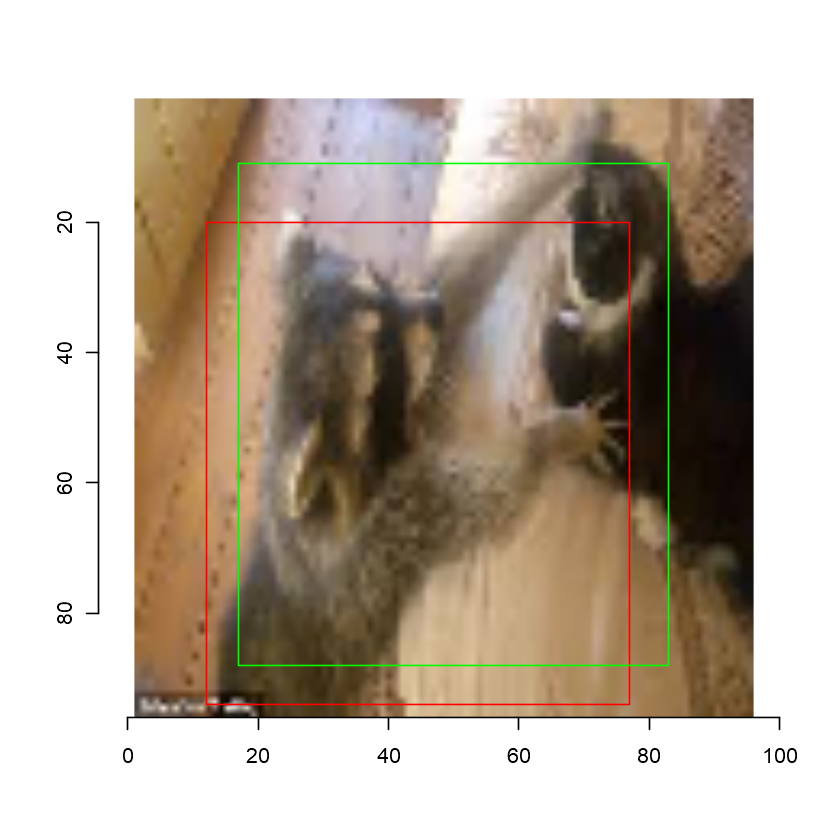

In [19]:
# plotting the test image with both actual bounding box and the predicted bounding box
plot(test_img_resized)
rect(xleft = x$x_min_resized,ybottom = x$y_min_resized,xright = x$x_max_resized ,ytop = x$y_max_resized,border = "red",lwd = 1)
rect(xleft = predicted_cord[1] ,ybottom = predicted_cord[2] ,xright = predicted_cord[3] + predicted_cord[1] ,ytop = predicted_cord[4] ,border = "green",lwd = 1)
